<a href="https://colab.research.google.com/github/abhinavgairola/Anomaly_Detection_OTC_Market/blob/main/EDA%2BMachine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This peace of code uses both AutoML Pycaret (logistic regression and LGBM) and Sklearns GridSearchCV, pipeline cabalities to train and tweak XgBoost classifier.

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
!pip install pycaret



     |████████████████████████████████| 81kB 3.4MB/s 
ERROR: pandas-profiling 2.11.0 has requirement requests>=2.24.0, but you'll have requests 2.23.0 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [82]:
import csv
from pycaret.classification import *
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
data = {}
with open('/content/drive/MyDrive/OTCMKT/Final_data.csv') as f:
  csv_file = csv.DictReader(f)
  for idx,row in enumerate(csv_file):
    data[idx]=(dict(row))  

In [83]:
df = pd.DataFrame(data)

In [84]:
df=df.reset_index()

In [85]:

df = df.T
columns = df.loc['index',:]
df = df.drop('index',axis=0)
df = df.rename(columns=columns)

In [86]:
df = df.set_index('Date')


In [87]:
df = df.replace('', '0')


In [88]:
columns = list(df.columns)

In [89]:
columns.remove('Ticker_name')

In [90]:
columns

['Indicator', 'Price', 'Sentiment_Score', 'Tweet_counts', 'Volume']

In [91]:
df[columns]=df[columns].astype(float)

In [92]:
columns.remove('Indicator')
columns.remove('Price')

##Dataset is not *normalized*

In [93]:
from sklearn import preprocessing
print(columns)
x = df[columns].values 
Standard_scaler = preprocessing.StandardScaler()
x_scaled = Standard_scaler.fit_transform(x)
df_new = pd.DataFrame(x_scaled)
df_new.columns = columns

['Sentiment_Score', 'Tweet_counts', 'Volume']


In [94]:
df_new['Indicator'] = list(df.Indicator.values)
df_new['Price'] = list(df.Price.apply(lambda x: math.log1p(x) ).values)
df_new['Tickers'] = list(df.Ticker_name.values)
df_new = df_new.set_index(df.index)

In [95]:
df_new

,Sentiment_Score,Tweet_counts,Volume,Indicator,Price,Tickers
Date,,,,,,
2016-09-16,0.432992,-0.289043,-0.520014,0.0,0.137597,RGBP
2016-09-20,2.464075,1.063349,-0.516444,0.0,0.130438,RGBP
2016-09-21,-0.002017,-0.221634,-0.521036,0.0,0.117961,RGBP
2016-09-22,-0.711980,-0.107881,-0.518695,0.0,0.128613,RGBP
2016-09-29,-0.387962,-0.267978,-0.521649,0.0,0.119457,RGBP
...,...,...,...,...,...,...
2016-05-24,0.293547,0.241802,-0.522189,0.0,0.073111,PRHL
2016-05-27,-0.652031,0.532504,-0.522661,0.0,0.063092,PRHL
2016-05-31,0.373833,0.671534,-0.517209,0.0,0.070691,PRHL


In [96]:
columns = list(df_new.columns)
columns.remove('Tickers')

In [97]:
columns

['Sentiment_Score', 'Tweet_counts', 'Volume', 'Indicator', 'Price']

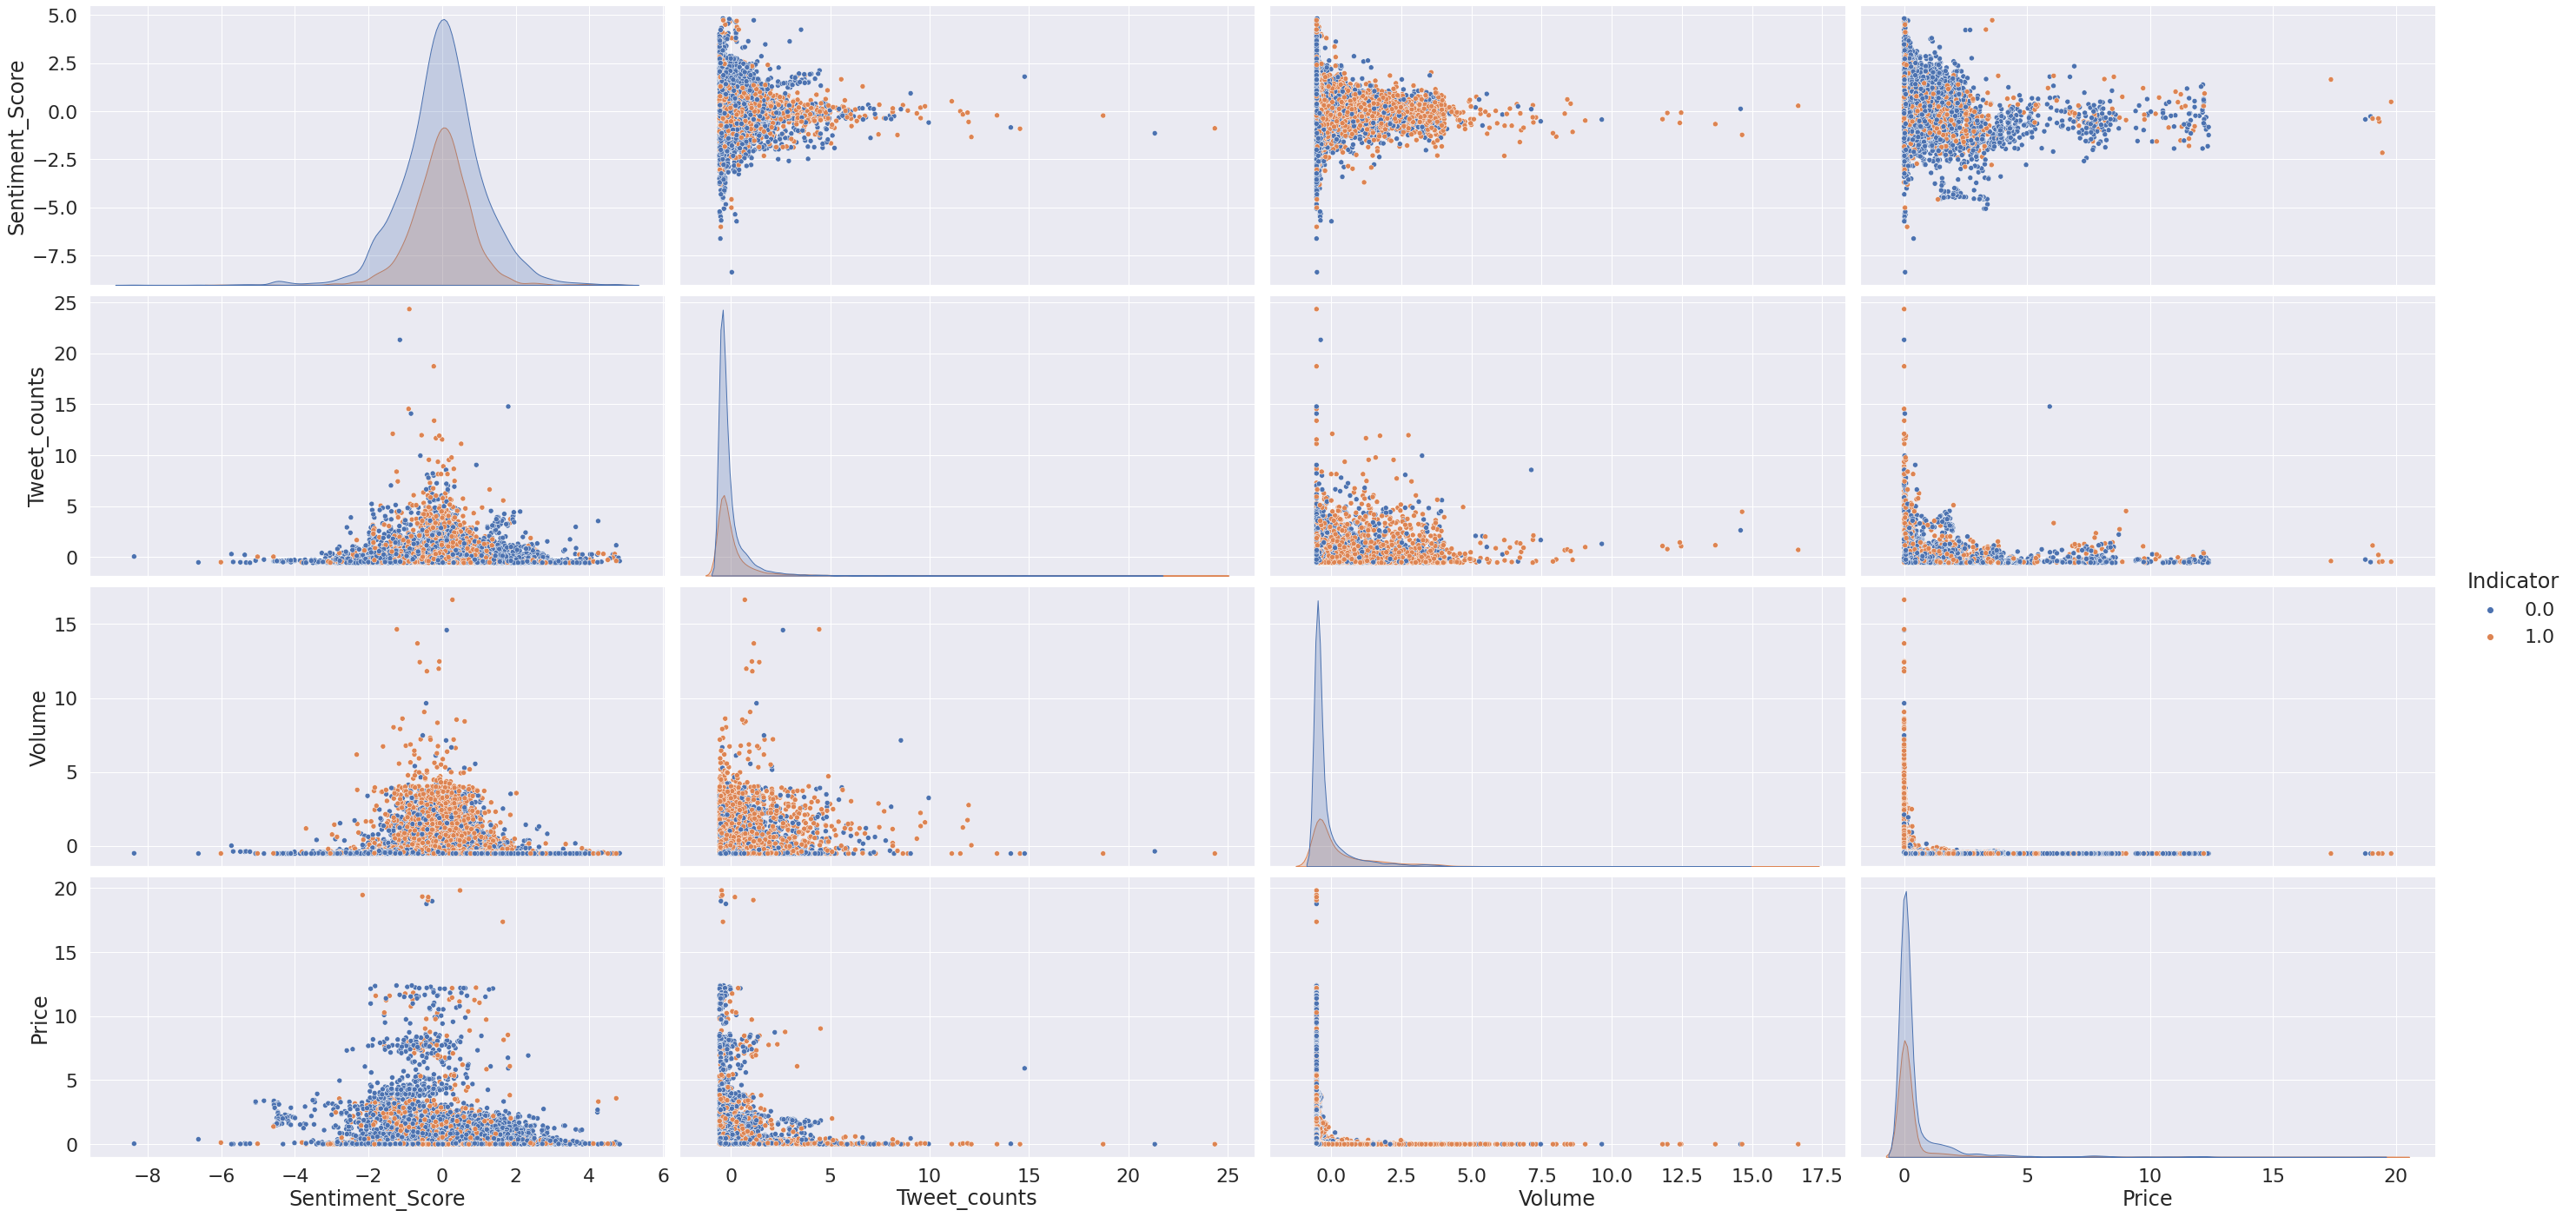

In [98]:
sns.set(font_scale = 2)
sns.pairplot(df_new[columns], hue='Indicator',height=5, 
    aspect=2)


## No collinearity is seen

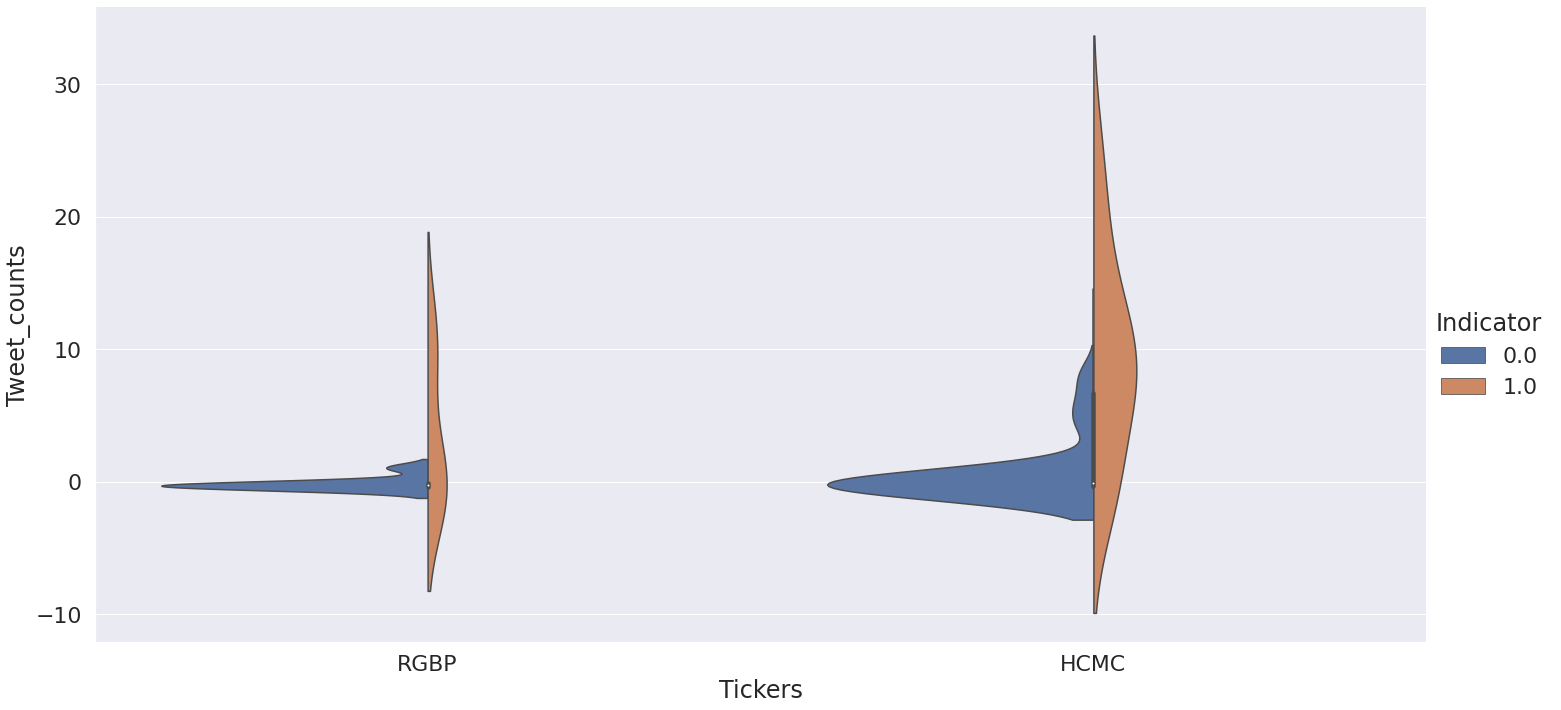

In [99]:

sns.catplot(
    data=df_new[0:50],
    x='Tickers',
    y='Tweet_counts',
    hue='Indicator',
    kind='violin',split=True,
    height=10,
    aspect=2)


(array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175.]),
 <a list of 9 Text major ticklabel objects>)

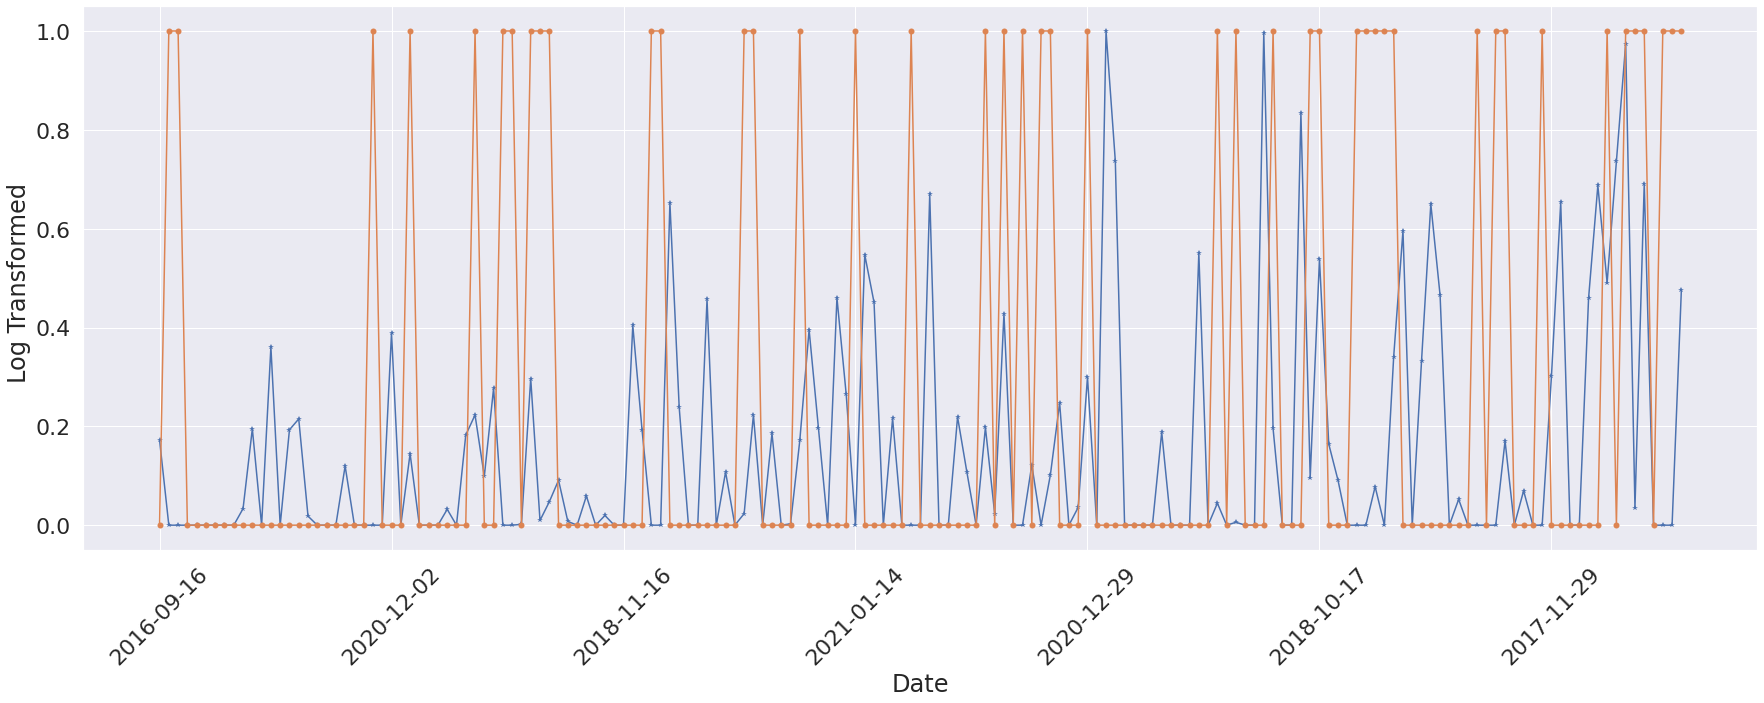

In [100]:
def neg(x):
  if x<0:
    return 0
  elif x>0:
    return x

plot_var = df_new.Sentiment_Score[0::90]
plot_var = plot_var.divide(plot_var.max()).apply(neg)
#plot_var = (plot_var-plot_var.min())/(plot_var.max()-plot_var.min())

plot_var2 = df_new.Indicator[0::90]
plot_var2 = plot_var2/plot_var2.max()
plot_var.plot(x=df_new.index,figsize=(30,10),marker='*')
plot_var2.plot(x=df_new.index,figsize=(30,10),marker='o')
plt.xlabel('Date')
plt.ylabel('Log Transformed ')
plt.xticks(rotation=45)

In [101]:
df_new

,Sentiment_Score,Tweet_counts,Volume,Indicator,Price,Tickers
Date,,,,,,
2016-09-16,0.432992,-0.289043,-0.520014,0.0,0.137597,RGBP
2016-09-20,2.464075,1.063349,-0.516444,0.0,0.130438,RGBP
2016-09-21,-0.002017,-0.221634,-0.521036,0.0,0.117961,RGBP
2016-09-22,-0.711980,-0.107881,-0.518695,0.0,0.128613,RGBP
2016-09-29,-0.387962,-0.267978,-0.521649,0.0,0.119457,RGBP
...,...,...,...,...,...,...
2016-05-24,0.293547,0.241802,-0.522189,0.0,0.073111,PRHL
2016-05-27,-0.652031,0.532504,-0.522661,0.0,0.063092,PRHL
2016-05-31,0.373833,0.671534,-0.517209,0.0,0.070691,PRHL


In [102]:
exp_clf = setup(df_new, target = 'Indicator',use_gpu=True)

,Description,Value
0,session_id,4580
1,Target,Indicator
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(14819, 6)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [103]:
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7447,0.7586,0.3406,0.6790,0.4536,0.3102,0.3417
1,0.7139,0.7375,0.2755,0.5855,0.3747,0.2192,0.2454
2,0.7187,0.7497,0.3034,0.5939,0.4016,0.2422,0.2655
3,0.7396,0.7291,0.2950,0.6884,0.4130,0.2787,0.3200
4,0.7232,0.7312,0.2826,0.6190,0.3881,0.2402,0.2710
5,0.7252,0.7462,0.2950,0.6209,0.4000,0.2500,0.2791
6,0.7242,0.7366,0.2764,0.6268,0.3836,0.2390,0.2722
7,0.7232,0.7249,0.2733,0.6241,0.3801,0.2356,0.2689
8,0.7223,0.7501,0.2857,0.6133,0.3898,0.2398,0.2691
9,0.7252,0.7216,0.2857,0.6259,0.3923,0.2455,0.2770


In [104]:
tuned_lr = tune_model(lr,optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7129,0.7533,0.6656,0.5309,0.5907,0.3739,0.3796
1,0.6840,0.7352,0.6316,0.4939,0.5543,0.3152,0.3209
2,0.7004,0.7521,0.6533,0.5146,0.5757,0.3491,0.3551
3,0.7068,0.7308,0.6180,0.5237,0.5670,0.3477,0.3504
4,0.6885,0.7304,0.6087,0.4987,0.5483,0.3141,0.3178
5,0.6837,0.7408,0.6677,0.4931,0.5673,0.3268,0.3361
6,0.6827,0.7305,0.5963,0.4910,0.5386,0.3003,0.3036
7,0.6827,0.7216,0.5745,0.4907,0.5293,0.2923,0.2943
8,0.6895,0.7472,0.6118,0.5000,0.5503,0.3168,0.3206
9,0.6924,0.7234,0.6056,0.5039,0.5501,0.3193,0.3225


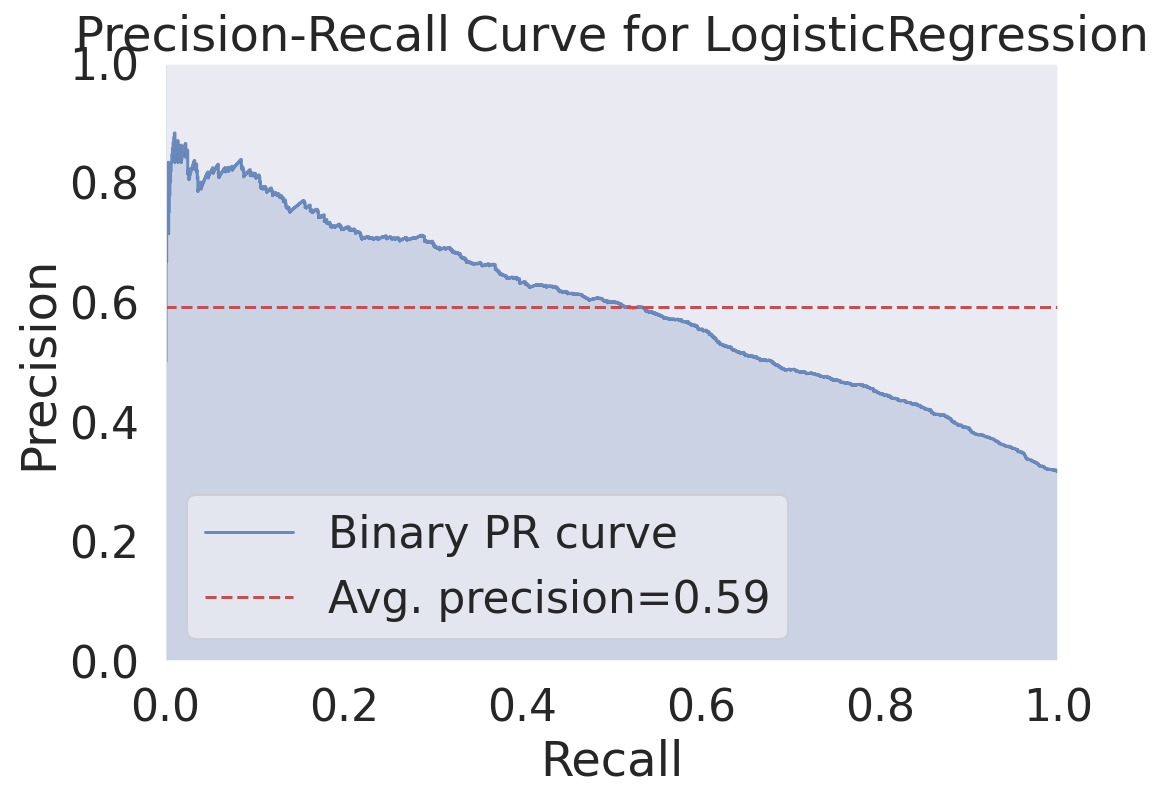

In [105]:
plot_model(lr,'pr',scale=2)

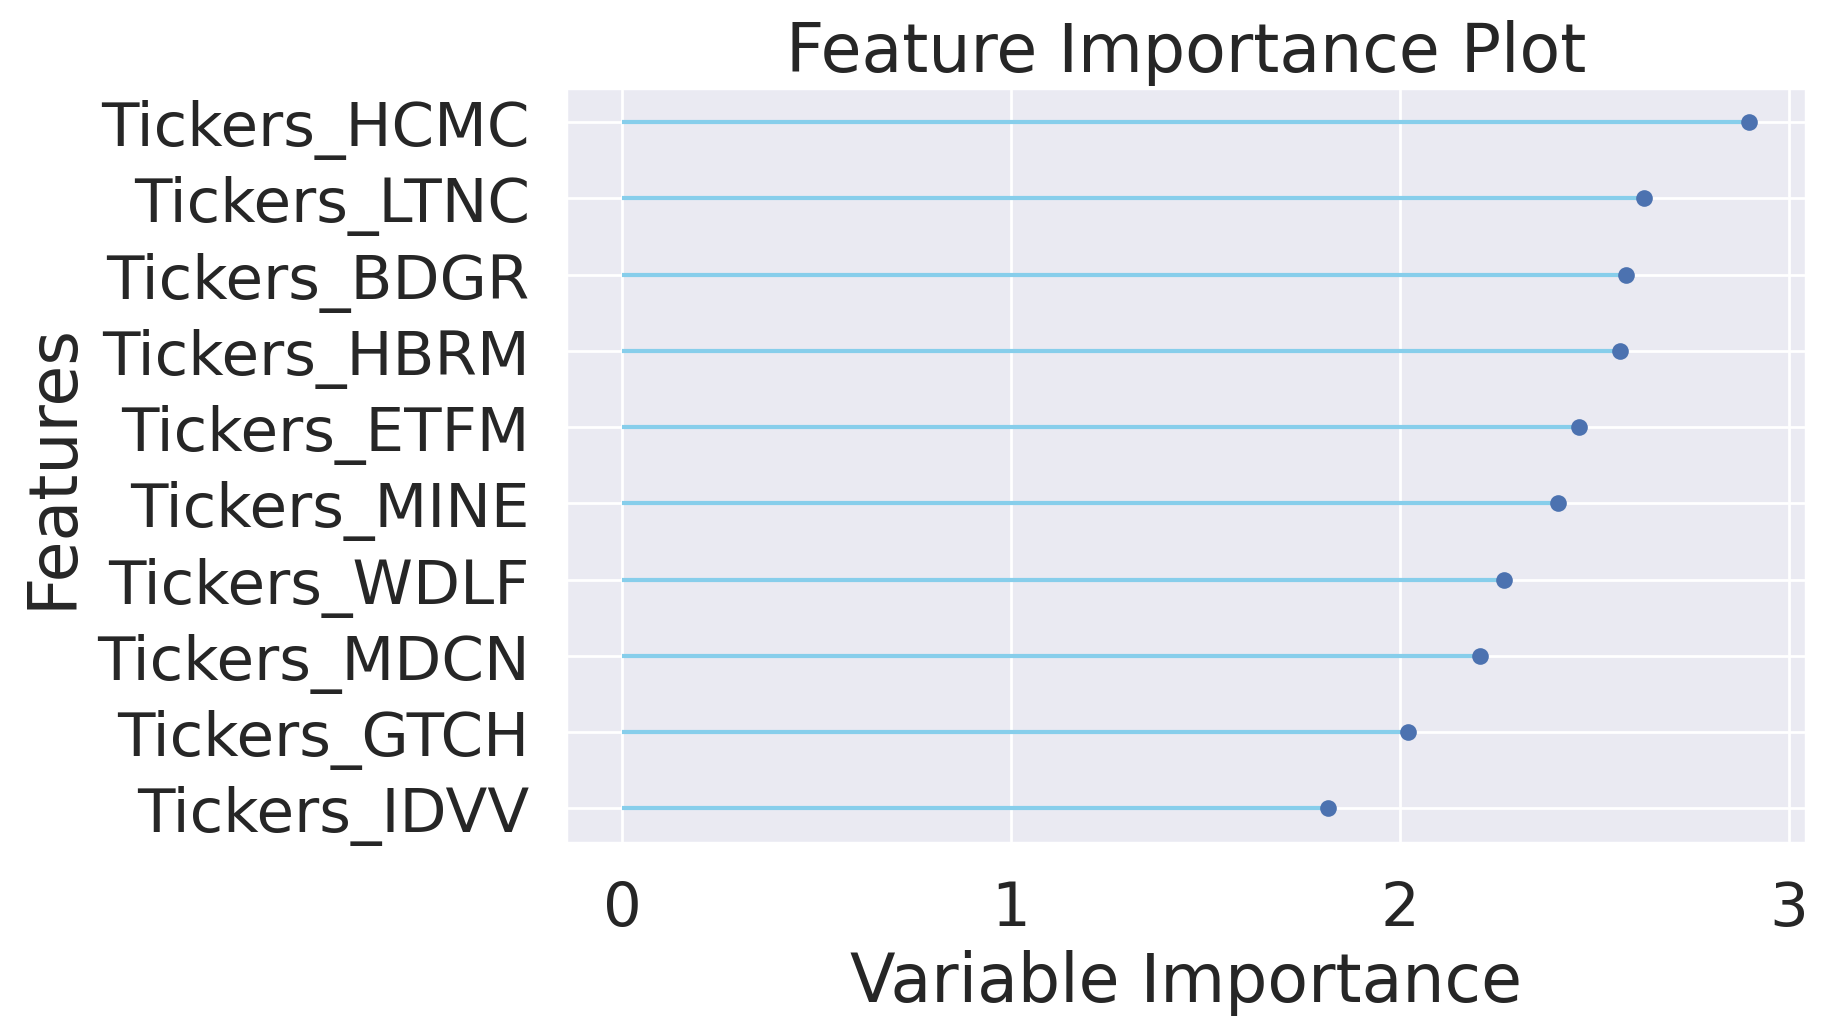

In [106]:
plot_model(lr,'feature',scale=2)

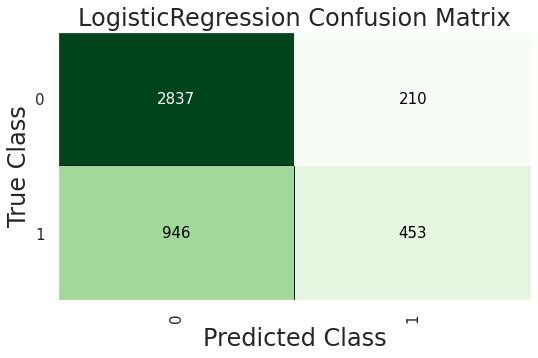

In [107]:
plot_model(lr,'confusion_matrix')

In [108]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7620,0.8076,0.4644,0.6696,0.5484,0.3940,0.4062
1,0.7476,0.7890,0.4272,0.6419,0.5130,0.3518,0.3651
2,0.7505,0.7874,0.4087,0.6600,0.5048,0.3501,0.3681
3,0.7570,0.7972,0.4068,0.6823,0.5097,0.3616,0.3830
4,0.7637,0.7929,0.4969,0.6584,0.5664,0.4083,0.4160
5,0.7570,0.7999,0.4814,0.6458,0.5516,0.3898,0.3977
6,0.7377,0.7941,0.4099,0.6168,0.4925,0.3252,0.3376
7,0.7541,0.8003,0.4689,0.6426,0.5422,0.3797,0.3885
8,0.7637,0.8077,0.4845,0.6638,0.5601,0.4040,0.4133
9,0.7338,0.7775,0.3820,0.6150,0.4713,0.3062,0.3217


In [109]:
tuned_lgbm = tune_model(lgbm,optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7129,0.7450,0.3777,0.5571,0.4502,0.2655,0.2747
1,0.7168,0.7385,0.3622,0.5707,0.4432,0.2658,0.2781
2,0.7071,0.7196,0.3498,0.5459,0.4264,0.2422,0.2530
3,0.6962,0.7274,0.2826,0.5200,0.3662,0.1888,0.2040
4,0.7097,0.7384,0.3665,0.5488,0.4395,0.2540,0.2634
5,0.7117,0.7464,0.3634,0.5545,0.4390,0.2562,0.2665
6,0.7020,0.7311,0.3571,0.5300,0.4267,0.2356,0.2440
7,0.7126,0.7488,0.3323,0.5632,0.4180,0.2437,0.2586
8,0.7078,0.7442,0.3447,0.5468,0.4229,0.2405,0.2519
9,0.7155,0.7205,0.3137,0.5771,0.4064,0.2403,0.2596


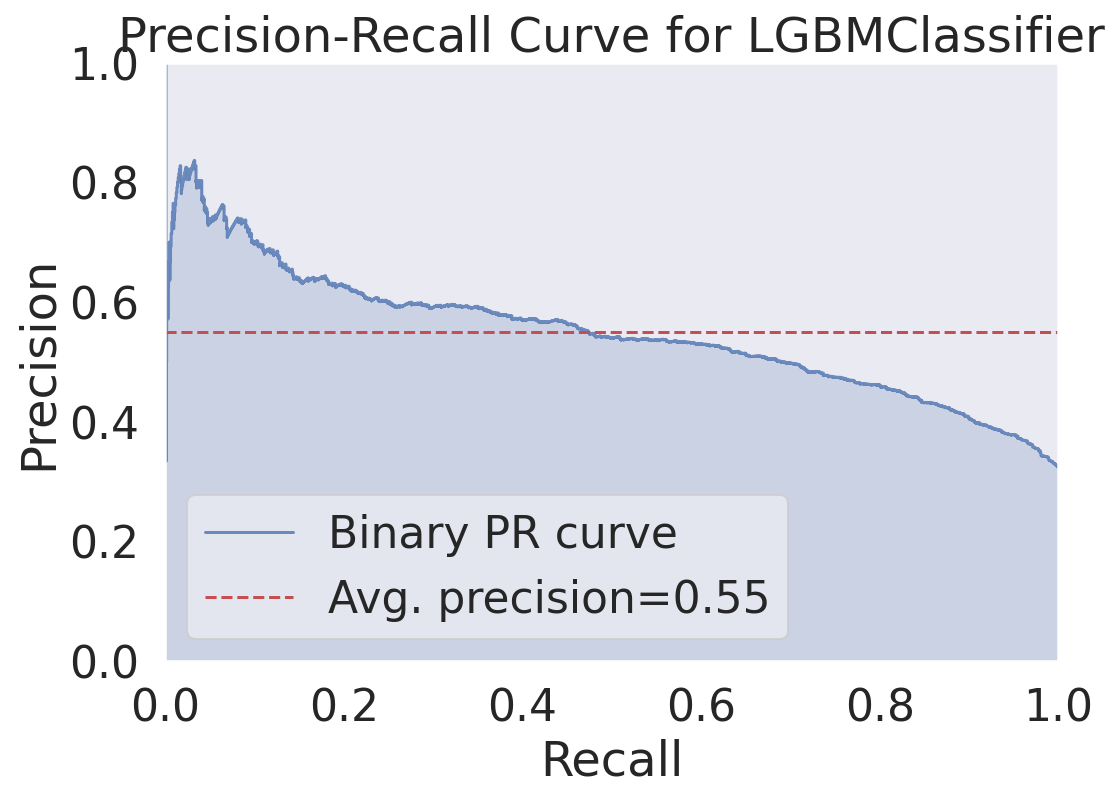

In [110]:
plot_model(tuned_lgbm,'pr',scale=2)

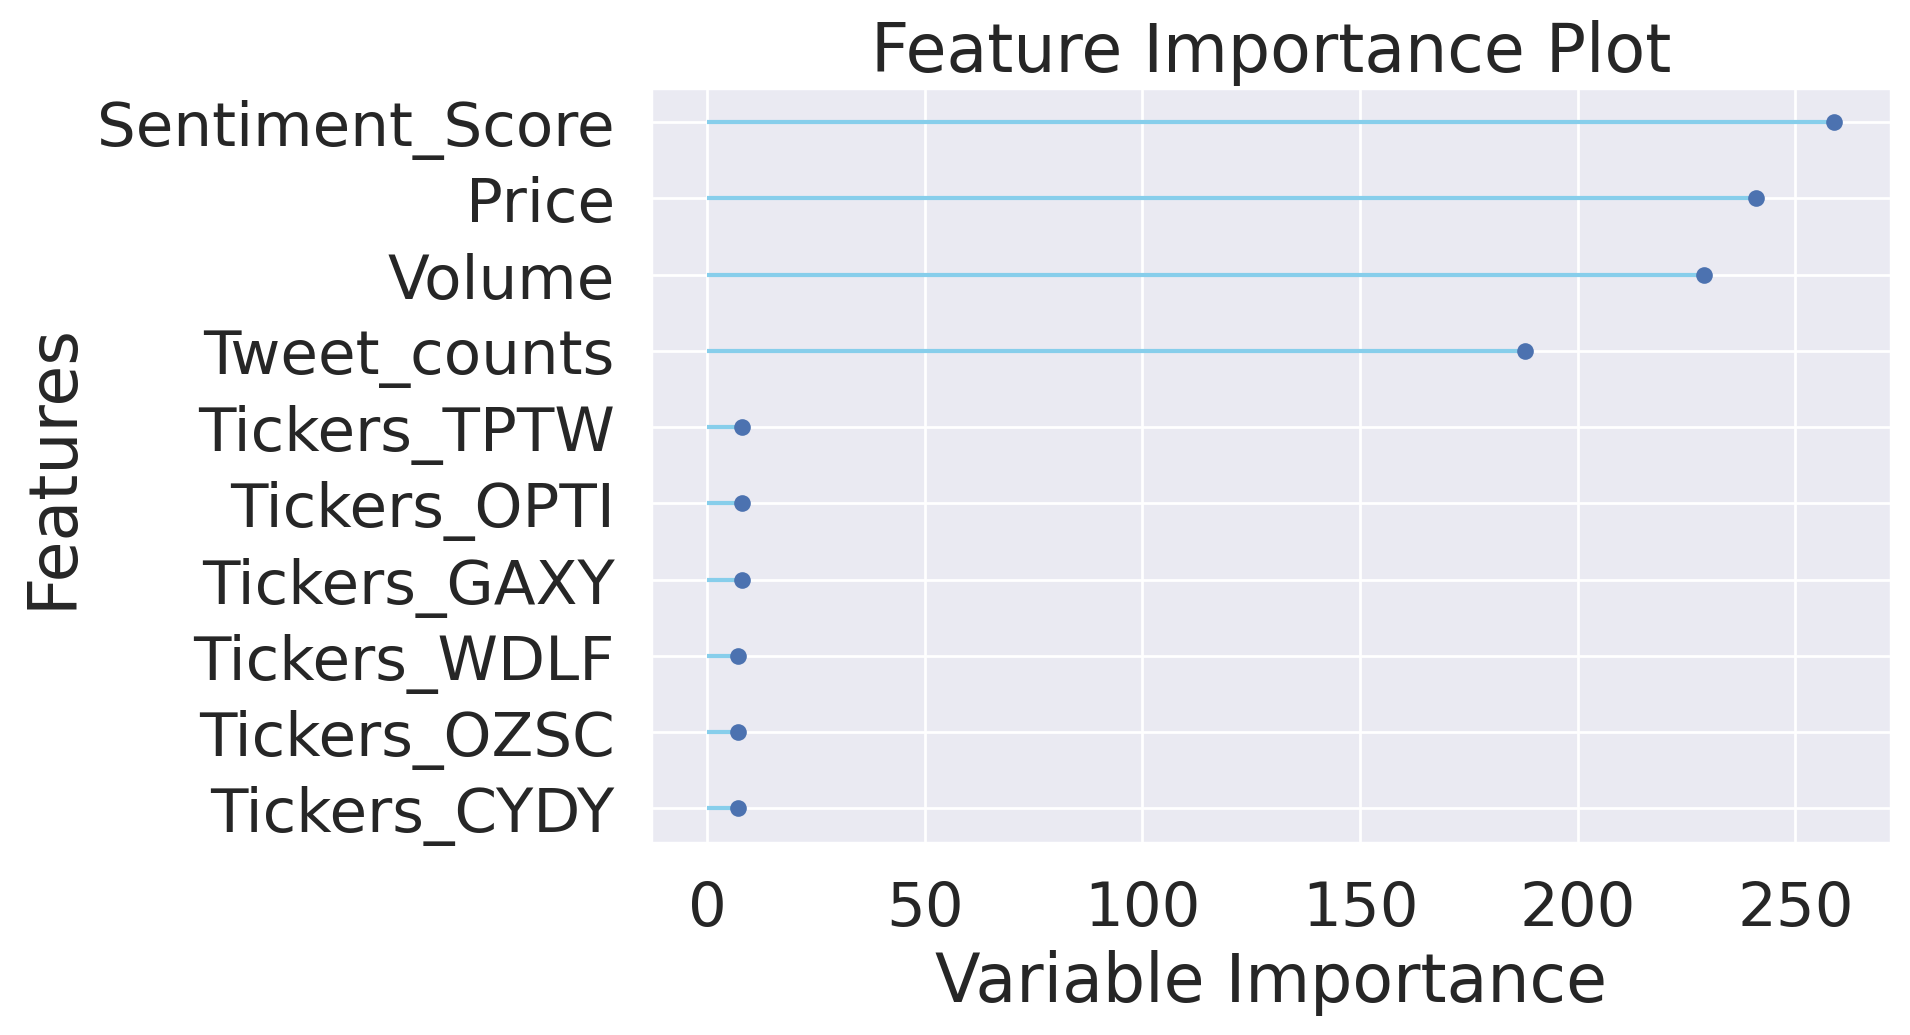

In [111]:
plot_model(tuned_lgbm,'feature',scale=2)

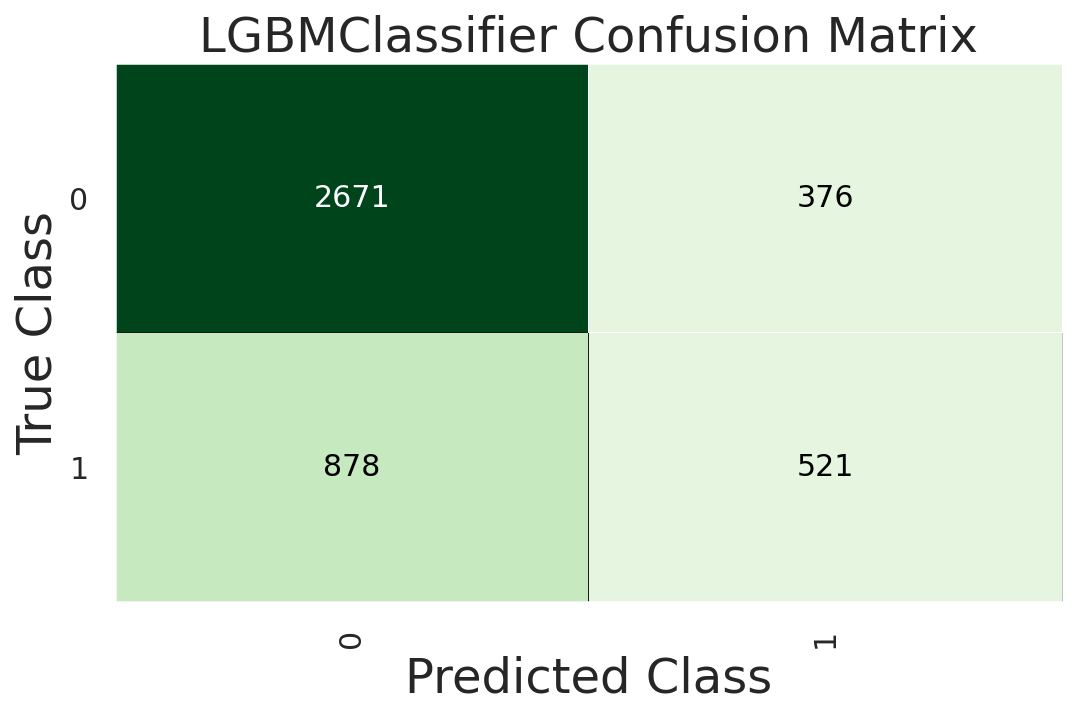

In [112]:
plot_model(tuned_lgbm,'confusion_matrix',scale=2)

## I will use scikit learn for xgboost classifier

In [220]:
import xgboost## Just for checking the help on xbhoost later on
#from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
## pipeline to combine normalizing and model fitting at once
from sklearn.pipeline import Pipeline
## for model optimization
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, precision_recall_curve,average_precision_score, auc

In [114]:
import sklearn.metrics
help(sklearn.metrics.confusion_matrix)

Help on function confusion_matrix in module sklearn.metrics._classification:

confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)
    Compute confusion matrix to evaluate the accuracy of a classification.
    
    By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
    is equal to the number of observations known to be in group :math:`i` and
    predicted to be in group :math:`j`.
    
    Thus in binary classification, the count of true negatives is
    :math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
    :math:`C_{1,1}` and false positives is :math:`C_{0,1}`.
    
    Read more in the :ref:`User Guide <confusion_matrix>`.
    
    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground truth (correct) target values.
    
    y_pred : array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.
    
    labels : array-like of shape (n_classes), default=

In [115]:


def pipeline_creator(model):

  pipe = Pipeline([('scaler', StandardScaler()), ('classifier',model)])

  return pipe

def XgboostClassifier(X_test,y_test,X_train,y_train):
  """
  Method to train a basic Xgboost classifier-- essentially a wrapper for my own purpose around the scikit learn methods
  This is without any optimization
  """
  #model = xgboost.sklearn.XGBClassifier()

  pipe = pipeline_creator(model)#Pipeline([('scaler', StandardScaler()), ('classifier',model)])

  pipe.fit(X_train,y_train)

  y_pred = pipe.predict(X_test)

  probabilities = pipe.predict_proba(X_test) ## Get prediction probabilities to be used in roc_curve methods

  accuracy = accuracy_score(y_test, y_pred)

  print("Accuracy{}".format (accuracy * 100.0))

  tpr_1, fpr_1, threshold_1 = roc_curve(y_test, probabilities[:,0]) ## Positivety and False positivity rate for class 0

  fpr_2, tpr_2, threshold_2 = roc_curve(y_test, probabilities[:,1]) ## Positivety and False positivity rate for class 1

  precision, recall, threshold = precision_recall_curve(y_test, probabilities[:,0])




  return [tpr_1,fpr_1,fpr_2,tpr_2,y_pred,model,pipe, precision, recall]












In [118]:
(GridSearchCV._get_param_names())

['cv',
 'error_score',
 'estimator',
 'iid',
 'n_jobs',
 'param_grid',
 'pre_dispatch',
 'refit',
 'return_train_score',
 'scoring',
 'verbose']

In [119]:
GridSearchCV.predict_proba

<function sklearn.model_selection._search.BaseSearchCV.predict_proba>

In [120]:
(xgboost.sklearn.XGBClassifier._get_param_names()) ## check the parameters of this classifier 

['base_score',
 'booster',
 'colsample_bylevel',
 'colsample_bynode',
 'colsample_bytree',
 'gamma',
 'learning_rate',
 'max_delta_step',
 'max_depth',
 'min_child_weight',
 'missing',
 'n_estimators',
 'n_jobs',
 'nthread',
 'objective',
 'random_state',
 'reg_alpha',
 'reg_lambda',
 'scale_pos_weight',
 'seed',
 'silent',
 'subsample',
 'verbosity']

## And will use get dummies method in pandas to generate one hot encoded categorical features.


In [121]:
df_xgboost = pd.get_dummies(df_new)

In [122]:
y = df_xgboost.Indicator
columns_x = list(df_xgboost.columns)
columns_x.remove('Indicator')
X = df_xgboost[columns_x]

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

Accuracy71.45748987854252


Text(0, 0.5, 'True positive rate')

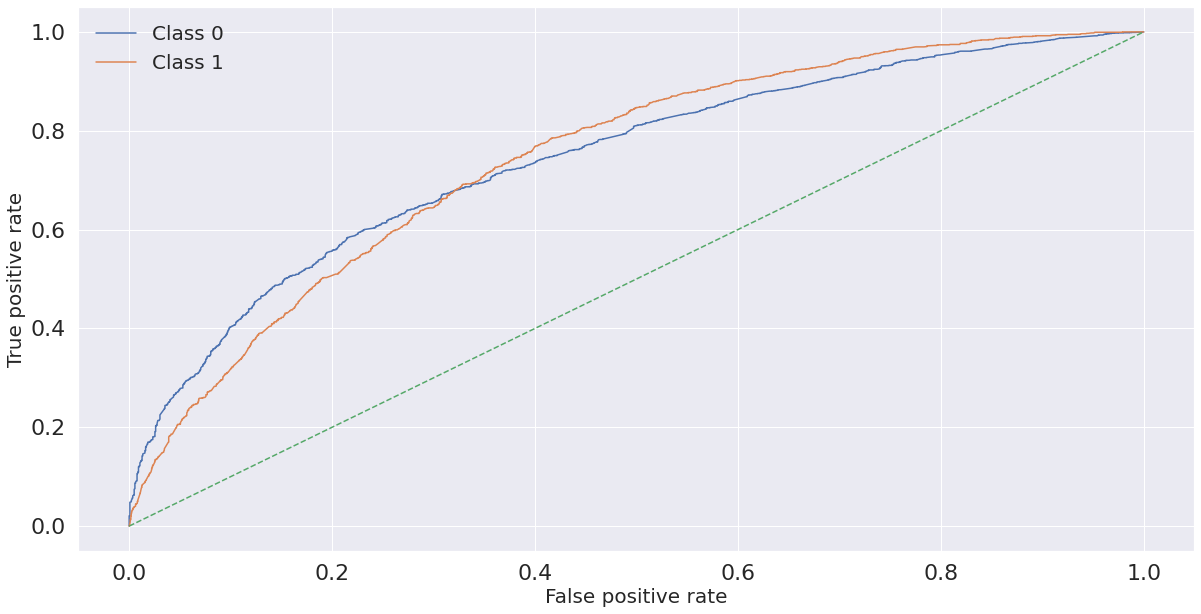

In [201]:
tpr_1, fpr_1, fpr_2, tpr_2, y_pred, model,pipe, precision, recall = XgboostClassifier(X_test,y_test,X_train,y_train)
plt.figure(figsize=(20,10))
plt.plot(fpr_1,tpr_1,label='Class 0')
plt.plot(fpr_2,tpr_2,label='Class 1')
plt.legend(loc='best',fontsize=20)
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),'--')
plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)

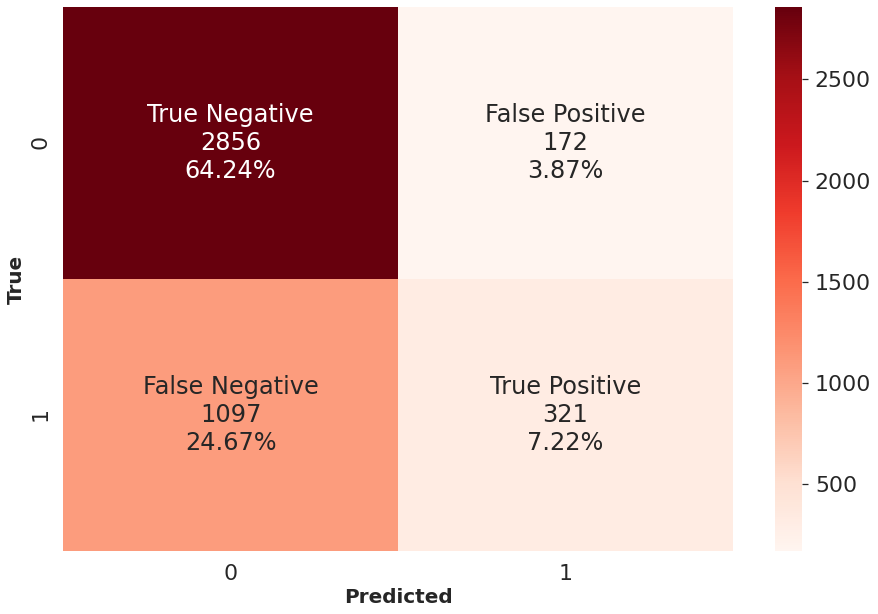

In [202]:



labels = ['True Negative','False Positive','False Negative','True Positive']
cf_matrix = confusion_matrix(y_test,y_pred)
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(labels,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(15,10))
sns.heatmap(cf_matrix,annot=labels,fmt='',cmap='Reds',cbar=True)
plt.xlabel(r'Predicted',fontsize=20,fontweight='bold')
plt.ylabel(r'True',fontsize=20,fontweight='bold')
plt.show()

## Have to add the numbers here and add the precision and recall curve too for the base classifier.

In [203]:
#https://xgboost.readthedocs.io/en/latest/parameter.html
## Optimizing the model using GridSearchCV


def predict_fit( model,folds, metric, X_train, y_train, X_test, y_test):

  """
  This method use gridsearchcv to optimize around the supplied parameters, fit, predict, compute accuracy, precision, recall and roc curve

  """

  grid = GridSearchCV(model, params, cv=folds, scoring=metric)

  grid.fit(X_train, y_train)

  feature_importance = grid.best_estimator_.feature_importances_

  y_pred = grid.best_estimator_.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)

  probabilities = grid.predict_proba(X_test)## Class prediction probabilities.

  tpr_1, fpr_1, threshold_1 = roc_curve(y_test, probabilities[:,0]) ## Positivety and False positivity rate for class 0

  fpr_2, tpr_2, threshold_2 = roc_curve(y_test, probabilities[:,1]) ## Positivety and False positivity rate for class 1

  precision, recall, threshold = precision_recall_curve(y_test, probabilities[:,0])

  return {'tpr_1':tpr_1,'fpr_1':fpr_1,'fpr_2':fpr_2,'tpr_2':tpr_2,'predictions':y_pred,'model':grid.best_estimator_,'accuracy':accuracy, 'precision':precision, 'recall':recall,'feature_importance':feature_importance}


params = {'learning_rate':[0.1,0.2,0.3],'max_depth':[5,6,7]}

model = xgboost.sklearn.XGBClassifier()

Output = predict_fit(model,6,'precision',X_train,y_train,X_test,y_test)
## Pipeline is erroring out for the time being it is fine to use GridSearchCV with XGBoost.
#pipe = pipeline_creator(model)
#grid = search_params(pipe, params, 6, 'precision')
#grid
#grid.fit(X_train,y_train)
#acc = predict(grid,X_train,y_train, X_test, y_test)
#print("Accuracry is {}".format(acc))
#parameter_tuning(pipe,params,6,'precision',X_test,y_test,X_train,y_train)

In [205]:
Output.keys()

dict_keys(['tpr_1', 'fpr_1', 'fpr_2', 'tpr_2', 'predictions', 'model', 'accuracy', 'precision', 'recall', 'feature_importance'])

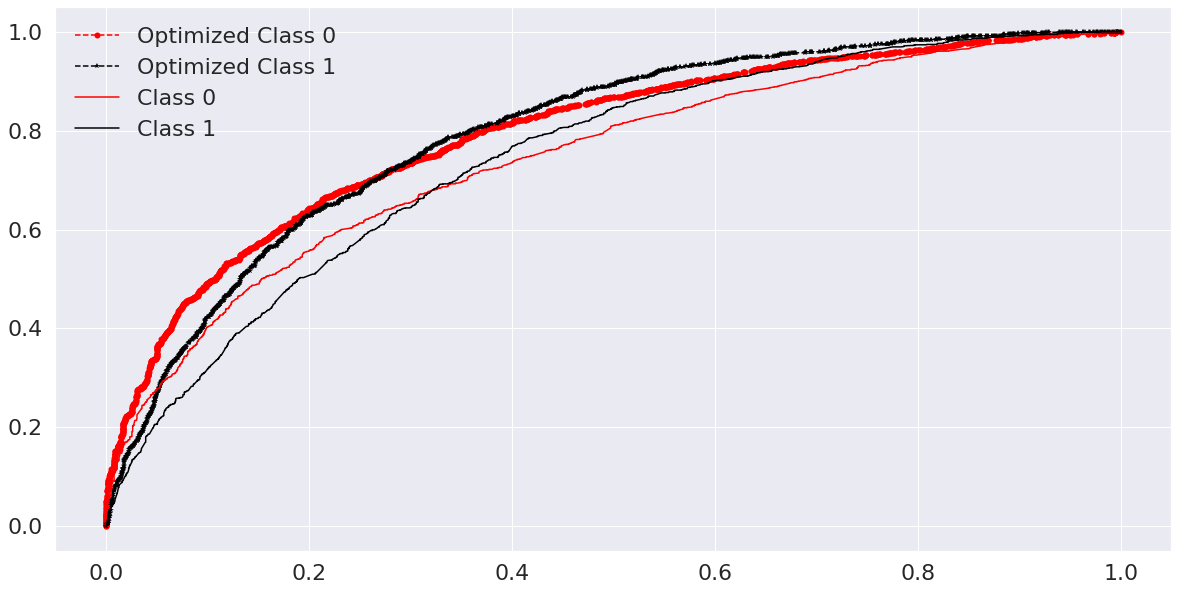

In [206]:
plt.figure(figsize=(20,10))
plt.plot(Output['fpr_1'],Output['tpr_1'],'--o',label='Optimized Class 0',color='red')
plt.plot(Output['fpr_2'],Output['tpr_2'],'--*',label='Optimized Class 1',color='black')
plt.plot(fpr_1,tpr_1,label='Class 0',color='red')
plt.plot(fpr_2,tpr_2,label='Class 1',color='black')
plt.legend(loc='best')


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

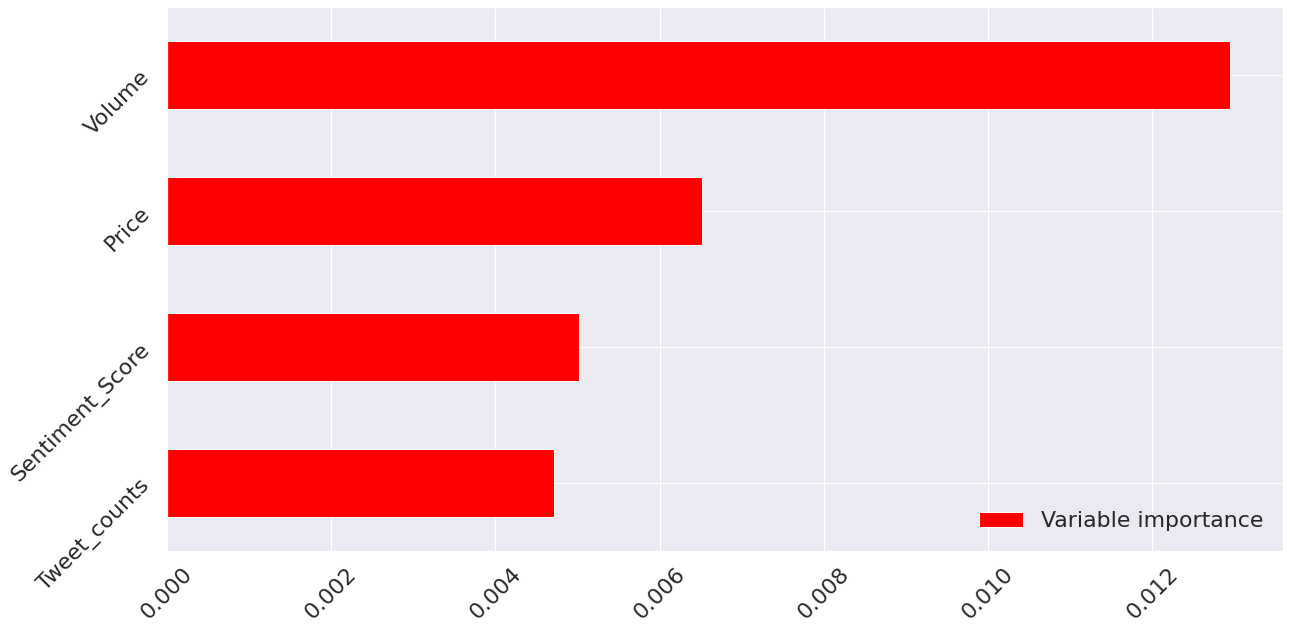

In [215]:

feature_names = list(df_xgboost.columns)

feature_names.remove('Indicator')

forest_importances = pd.DataFrame((Output['model']).feature_importances_, index=feature_names).rename(columns={0:'Variable importance'})
forest_importances[0:4].sort_values(by='Variable importance').plot(kind='barh',rot=0,color='red',figsize=(20,10))
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

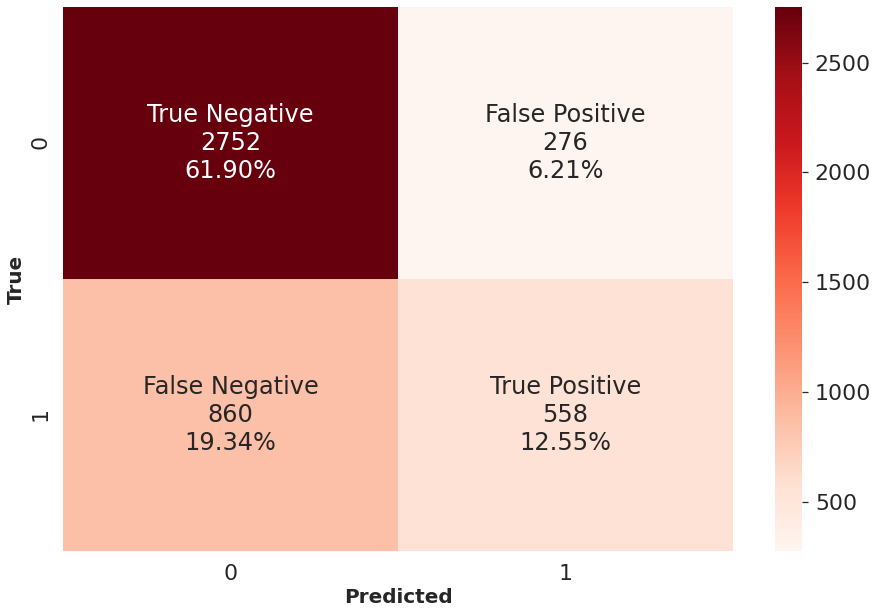

In [216]:


labels = ['True Negative','False Positive','False Negative','True Positive']
cf_matrix = confusion_matrix(y_test,Output['predictions'])
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(labels,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(15,10))
sns.heatmap(cf_matrix,annot=labels,fmt='',cmap='Reds',cbar=True)
plt.xlabel(r'Predicted',fontsize=20,fontweight='bold')
plt.ylabel(r'True',fontsize=20,fontweight='bold')
plt.show()


## I will plot precision and recall--this should end the modeling part after I finish CatBoost classifier with Sklearn.

## Optimization results in a better True positive classification

In [217]:
#!pip install catboost


In [218]:
#from catboost import CatBoostClassifier